# Определение возраста покупателей c помощью архитектуры ResNet50

Данная задача решалась в рамках прохождения Яндекс.Практикум в среде Jupyterhub (анализ данных) и на GPU Яндекса (обучение). 

Данные для анализа и обучения извлекались с помощью метода `ImageDataGenerator`.

# Содержание
1. [Исследовательский анализ данных](#1)
1. [Обучение модели](#2)
1. [Результат обучения](#3)
1. [Анализ полученной модели](#4) 

<a name='1'></a>
## 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam  

**Данные:**
- final_files - папка со всеми изображениямии;
- labels.csv - таблица с двумя колонками: file_name и real_age.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
display(labels.head())
print('Строк-дубликатов в таблице:', labels.duplicated().sum()) 

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Строк-дубликатов в таблице: 0


Датасет содержит 7591 пару значений "изображение - возраст". 
Пропуски и дубликаты отсутствуют. 


Рассмотрим распределение возрастов в данных. 

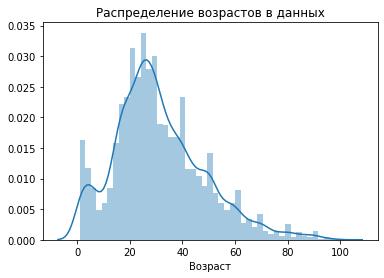

In [4]:
sns.distplot(labels.real_age)
plt.title('Распределение возрастов в данных')
plt.xlabel('Возраст')
plt.show()

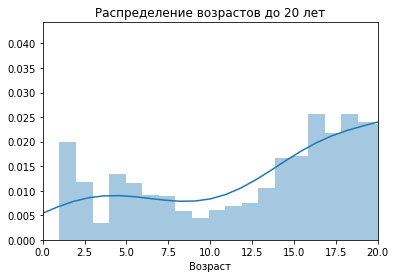

In [5]:
sns.distplot(labels.real_age, bins = 100)
plt.xlabel('Возраст')
plt.title('Распределение возрастов до 20 лет')
plt.xlim(0, 20)
plt.show()

На изображениях в основном представлены люди в возрасте от 20 до 40 лет. Наблюдается также заметное количество детей до 7,5 лет.

In [6]:
#загрузка данных для просмотра 
datagen = ImageDataGenerator(rescale=1/255) 

train_gen_flow = datagen.flow_from_dataframe(dataframe = labels, 
                                             directory = '/datasets/faces/final_files/', 
                                             x_col='file_name', 
                                             y_col = 'real_age', 
                                             target_size=(224,224), 
                                             batch_size=32, 
                                             class_mode = 'raw', 
                                             subset = 'training', 
                                             seed = 42)

X_analysis, y_analysis = next(train_gen_flow)

Found 7591 validated image filenames.


In [7]:
print('Размерности батча') 
print('X: {}, y: {}'.format(X_analysis.shape, y_analysis.shape))

Размерности батча
X: (32, 224, 224, 3), y: (32,)


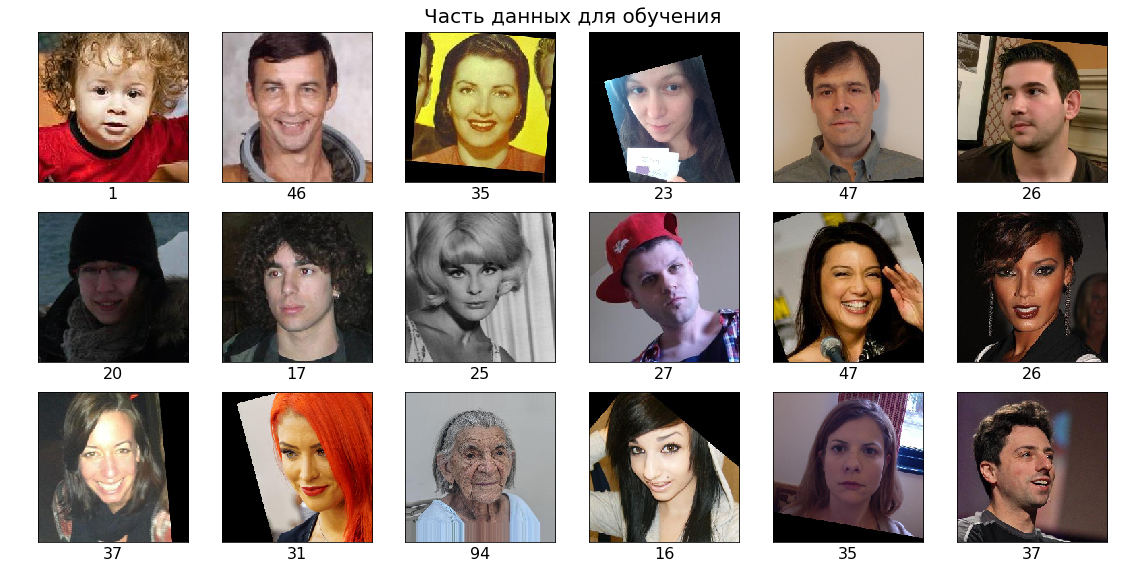

In [9]:
fig = plt.figure(figsize=(16, 8))
plt.title('Часть данных для обучения', fontsize=20, pad=10)
plt.axis('off')

for i in range(18): 
    fig.add_subplot(3, 6, i+1)
    plt.imshow(X_analysis[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(y_analysis[i], fontsize=16)
    plt.tight_layout()

Изображения цветные, без значительных дефектов, многие повернуты так, чтобы лицо было изображено строго вертикально. 

<a name='2'></a>
## 2. Обучение модели

Следующий код запускался на GPU Яндекса, поэтому в данной тетради вызовы функций отсутствуют.
Все переменные, не созданные в тетради ранее, передавались сервером.  


Результат обучения модели сохранен в [ячейке Markdown](#3)

In [10]:
def load_train(path): 
    '''
    Downloads train data from server 
    '''
    labels = pd.read_csv(path+'/labels.csv')
    datagen = ImageDataGenerator(rescale=1/255, 
                                 horizontal_flip = True, #to increase train data amount
                                 validation_split = 0.25) 
    
    train_gen_flow = datagen.flow_from_dataframe(dataframe = labels, 
                                             directory = path + '/final_files',  
                                             x_col='file_name', 
                                             y_col = 'real_age', 
                                             target_size=(224,224), 
                                             batch_size=32, 
                                             class_mode = 'raw', 
                                             subset = 'training',
                                             seed = 42)    
    return train_gen_flow

In [11]:
def load_test(path): 
    '''
    Downloads test data from server
    '''
    labels = pd.read_csv(path+'/labels.csv')
    datagen = ImageDataGenerator(rescale=1/255, 
                                 validation_split = 0.25)
    
    test_gen_flow = datagen.flow_from_dataframe(dataframe = labels, 
                                                directory = path + '/final_files',  
                                                x_col = 'file_name', 
                                                y_col = 'real_age', 
                                                target_size = (224, 224), 
                                                batch_size = 32, 
                                                class_mode = 'raw', 
                                                subset = 'validation', 
                                                seed = 42) 
    return test_gen_flow

In [12]:
def create_model(input_shape): 
    '''
    Creates ResNet50 model
    '''
    
    #ResNet arcitecture 
    resnet = ResNet50(input_shape = input_shape, 
                      weights = 'imagenet',
                      include_top = False)
    #additional layers 
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1, activation = 'relu'))   
    
    #compilation 
    optimizer = Adam(lr = 0.0007)
    model.compile(optimizer=optimizer, 
                  loss = 'mse', 
                  metrics = ['mae'])
    return model 

In [13]:
def train_model(model, train_data, test_data,
                batch_size=None, 
                epochs=10, 
                steps_per_epoch=None, 
                validation_steps=None):
    '''
    Trains the model, returned by create_model function
    '''
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data = test_data, 
              batch_size = batch_size,
              epochs = epochs, 
              steps_per_epoch = steps_per_epoch, 
              validation_steps = validation_steps, 
              shuffle = True, verbose = 2)
    return model

<a name = '3'></a>

## 3. Результат обучения
```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps

Epoch 1/10
178/178 - 52s - loss: 218.2469 - mae: 11.1114 - val_loss: 628.8891 - val_mae: 21.8472
Epoch 2/10
178/178 - 42s - loss: 117.7869 - mae: 8.2826 - val_loss: 370.3067 - val_mae: 14.3082
Epoch 3/10
178/178 - 41s - loss: 84.9383 - mae: 7.0554 - val_loss: 311.5285 - val_mae: 13.1095
Epoch 4/10
178/178 - 41s - loss: 58.1729 - mae: 5.8025 - val_loss: 229.0564 - val_mae: 11.9782
Epoch 5/10
178/178 - 41s - loss: 40.1906 - mae: 4.8793 - val_loss: 139.1883 - val_mae: 9.2845
Epoch 6/10
178/178 - 41s - loss: 29.9113 - mae: 4.1957 - val_loss: 106.1330 - val_mae: 8.0248
Epoch 7/10
178/178 - 41s - loss: 24.1618 - mae: 3.7846 - val_loss: 85.3595 - val_mae: 7.0304
Epoch 8/10
178/178 - 42s - loss: 18.1229 - mae: 3.2960 - val_loss: 85.2188 - val_mae: 7.1172
Epoch 9/10
178/178 - 42s - loss: 14.8651 - mae: 2.9467 - val_loss: 83.1579 - val_mae: 6.8478
Epoch 10/10
178/178 - 41s - loss: 11.9708 - mae: 2.6610 - val_loss: 89.5560 - val_mae: 7.0178
```

<a name='4'></a>
## 4. Анализ полученной модели

На валидационной выборке модель возвращает mae менее 8. 

С начала обучения разница в mae для валидационной и обучающей выборок различается в среднем в 2-2,5 раза. 

К концу обучения mae на обучающей выборке крайне низка по сравнению с валидационной, можем сделать вывод, что модель переобучается. До 9 эпохи, несмотря на переобучение, метрика стабильно снижалась на обоих выборках, поэтому оно было допустимым. На 10 эпохе mae на валидационной выборке снова выросла, в то время как на обучающей - продолжила снижаться. На данном этапе переобучение модели перестает быть приемлемым, с данной архитектурой наилучший результат был достигнут на 9 эпохе. 

Субъективно наибольшее влияние на качество модели оказало количество эпох, затем архитектура слоев поверх ResNet. Learning rate пригоден скорее для тонкой настройки, т.к. значение по умолчанию, равное 0.001, уже позволяет показывать адекватное качество модели. 

**Замечание:** использование метрики MAE было предусмотрено заданием. К сожалению, данная метрика сложно интерпретируема, поэтому говорить о реальном качестве и применимости полученной модели сложно. 

Метрика MAE показывает среднее отклонение прогнозов модели от реальных значений. Минимальное значение MAE на валидационной выборке составляет 6,8, что говорит о том, что предсказания "промахиваются" в среднем на 7 лет. Полученная модель скорее непригодна для реального коммерческого использования. 

На данном этапе неясно, что дает такую ошибку. Т.к. модель демонстрирует переобучение, можно предположить, что обучающая выборка не охватила необходимое многообразие данных. 